# Cyberbullying Tweets Classifier Model using Natural Language Processing

## Importing necessary libraries.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string
import emoji

from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
tweet = pd.read_csv('cyberbullying_tweets.csv')
tweet.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## EDA - Exploring and Analyzing the tweets dataset.

In [3]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [4]:
tweet.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [5]:
tweet.nunique()

tweet_text            46017
cyberbullying_type        6
dtype: int64

In [6]:
tweet.isna().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [7]:
tweet['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [8]:
tweet['tweet_text'].duplicated().sum()

1675

In [9]:
tweet.drop_duplicates("tweet_text", inplace=True)

In [10]:
tweet['tweet_text'].duplicated().sum()

0

### EDA through Visualizing.

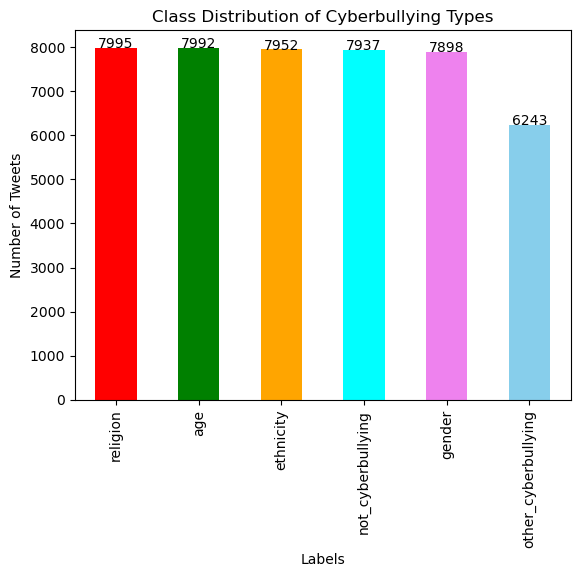

In [11]:
class_counts = tweet['cyberbullying_type'].value_counts()
ax = class_counts.plot(kind='bar', color=['Red', 'Green', 'Orange', 'cyan', 'violet', 'skyblue'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 3), textcoords='offset points')

plt.title('Class Distribution of Cyberbullying Types')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

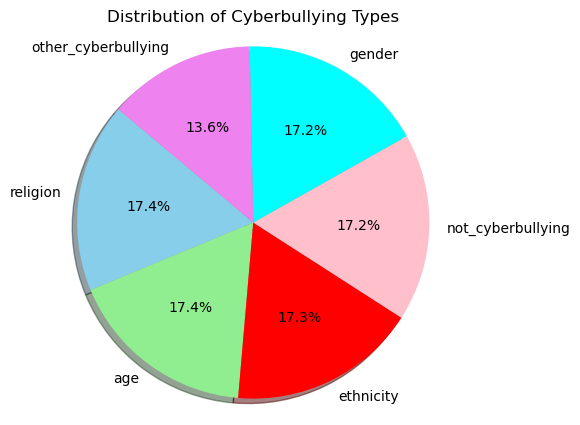

In [12]:
cyberbullying_counts = tweet['cyberbullying_type'].value_counts()
labels = cyberbullying_counts.index.tolist()
sizes = cyberbullying_counts.values.tolist()
colors = ['skyblue','lightgreen','red','pink', 'cyan', 'violet']
plt.figure(figsize=(5, 5))
plt.pie(sizes,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Distribution of Cyberbullying Types')
plt.show()

## Data Preprocessing

#### Removing stopwords like Articles,Conjunction,Prepositions,Pronouns, Common Verbs

In [13]:
stop = stopwords.words('english')
regex = re.compile('[%s]' % re.escape(string.punctuation))

def test_re(s):
    return regex.sub('', s)

tweet['content_without_stopwords'] = tweet['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
tweet['content_without_punctuation'] = tweet['content_without_stopwords'].apply(lambda x: regex.sub('',x))

del tweet['content_without_stopwords']
del tweet['tweet_text']

In [14]:
tweet.head()

,cyberbullying_type,content_without_punctuation
0,not_cyberbullying,In words katandandre food crapilicious mkr
1,not_cyberbullying,Why aussietv white MKR theblock ImACelebrityAU...
2,not_cyberbullying,XochitlSuckkks classy whore Or red velvet cupc...
3,not_cyberbullying,JasonGio meh P thanks heads up concerned anoth...
4,not_cyberbullying,RudhoeEnglish This ISIS account pretending Kur...


#### Breaking down the text into small units by tokenizing.

In [15]:
porter_stemmer = PorterStemmer()

tweet['content_tokenize'] = tweet['content_without_punctuation'].apply(
    lambda text: ' '.join(porter_stemmer.stem(word) for word in nltk.word_tokenize(text))
)

#df.drop(columns=['content_without_punctuation'], inplace=True)
del tweet['content_without_punctuation']

In [16]:
tweet.head()

,cyberbullying_type,content_tokenize
0,not_cyberbullying,in word katandandr food crapilici mkr
1,not_cyberbullying,whi aussietv white mkr theblock imacelebrityau...
2,not_cyberbullying,xochitlsuckkk classi whore or red velvet cupcak
3,not_cyberbullying,jasongio meh p thank head up concern anoth ang...
4,not_cyberbullying,rudhoeenglish thi isi account pretend kurdish ...


#### Removing Digits from the text.

In [17]:
tweet['content'] = tweet['content_tokenize'].str.replace(r'\d+', '', regex=True)

tweet.sample(3)

,cyberbullying_type,content_tokenize,content
3298,not_cyberbullying,israelites234 lahavharkov aliyaist gilhoffman ...,israelites lahavharkov aliyaist gilhoffman jer...
65,not_cyberbullying,follow new report of brandonmcinerney shoot de...,follow new report of brandonmcinerney shoot de...
41294,ethnicity,“ tayyoung fuck obama dumb ass nigger ” lt thi...,“ tayyoung fuck obama dumb ass nigger ” lt thi...


In [18]:
del tweet['content']

In [19]:
tweet.head()

,cyberbullying_type,content_tokenize
0,not_cyberbullying,in word katandandr food crapilici mkr
1,not_cyberbullying,whi aussietv white mkr theblock imacelebrityau...
2,not_cyberbullying,xochitlsuckkk classi whore or red velvet cupcak
3,not_cyberbullying,jasongio meh p thank head up concern anoth ang...
4,not_cyberbullying,rudhoeenglish thi isi account pretend kurdish ...


#### Removing Emojis from the text.

In [20]:
tweet['content_tokenize'][21]

'kid love😘❤ mohamad bin zay citi مدينة محمد بن زايد httptco0xrozsnn'

In [21]:
tweet['content_tokenize'] = tweet['content_tokenize'].apply(lambda x: emoji.replace_emoji(x, ''))

In [22]:
tweet['content_tokenize'][21]

'kid love mohamad bin zay citi مدينة محمد بن زايد httptco0xrozsnn'

#### Removing remaining stuff like urls, underscores, special characters.

In [23]:
tweet['content_tokenize'] = tweet['content_tokenize'].apply(lambda x:re.sub(r'((www.[^s]+)|(http\S+))', ' ', x))
tweet['content_tokenize'] = tweet['content_tokenize'].str.replace("[\d_]", ' ',regex = True)
tweet['content_tokenize'] = tweet['content_tokenize'].str.lower()
tweet['content_tokenize'] = tweet['content_tokenize'].str.replace('[^\w\s]', '',regex = True)
tweet['content_tokenize'] = tweet['content_tokenize'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))

In [24]:
tweet.rename(columns={'content_tokenize': 'tweet_text'}, inplace=True)

In [25]:
tweet.head()

,cyberbullying_type,tweet_text
0,not_cyberbullying,in word katandandr food crapilici mkr
1,not_cyberbullying,whi aussietv white mkr theblock imacelebrityau...
2,not_cyberbullying,xochitlsuckkk classi whore or red velvet cupcak
3,not_cyberbullying,jasongio meh thank head up concern anoth angri...
4,not_cyberbullying,rudhoeenglish thi isi account pretend kurdish ...


### Classifying the words based on each cyberbullying type.

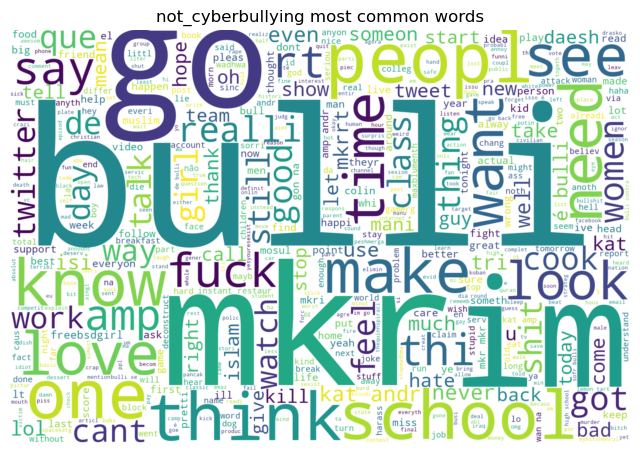

In [26]:
text1 = ''.join(tweet[tweet['cyberbullying_type'] == 'not_cyberbullying'].tweet_text.values)
wc1 = WordCloud(background_color="white", max_words=500, width=1500, height=1000).generate(text1)
plt.figure(figsize=(8,8))
plt.imshow(wc1, interpolation='bilinear')
plt.title('not_cyberbullying most common words')
plt.axis('off')
plt.show()

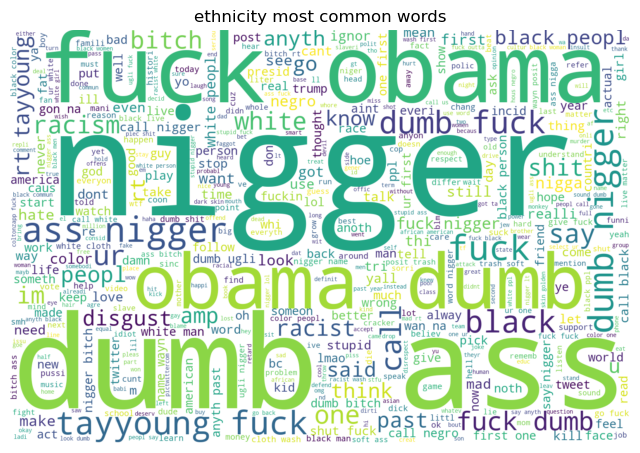

In [27]:
text2 = ''.join(tweet[tweet['cyberbullying_type'] == 'ethnicity'].tweet_text.values)
wc1 = WordCloud(background_color="white", max_words=500, width=1500, height=1000).generate(text2)
plt.figure(figsize=(8,8))
plt.imshow(wc1, interpolation='bilinear')
plt.title('ethnicity most common words')
plt.axis('off')
plt.show()

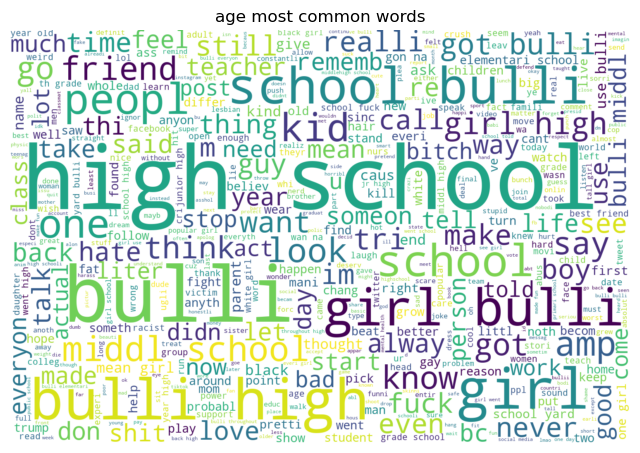

In [28]:
text3 = ''.join(tweet[tweet['cyberbullying_type'] == 'age'].tweet_text.values)
wc1 = WordCloud(background_color="white", max_words=500, width=1500, height=1000).generate(text3)
plt.figure(figsize=(8,8))
plt.imshow(wc1, interpolation='bilinear')
plt.title('age most common words')
plt.axis('off')
plt.show()

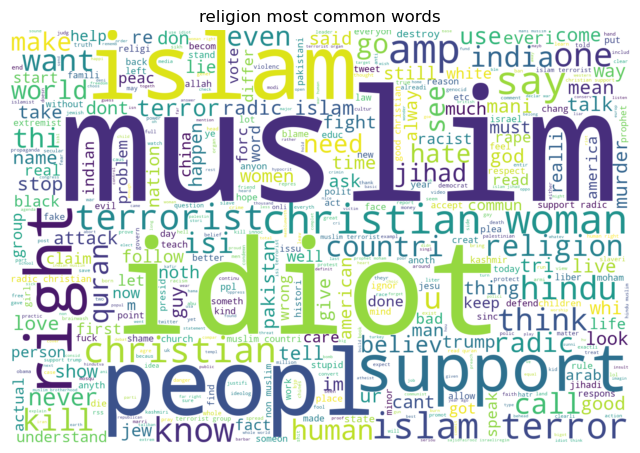

In [29]:
text4 = ''.join(tweet[tweet['cyberbullying_type'] == 'religion'].tweet_text.values)
wc1 = WordCloud(background_color="white", max_words=500, width=1500, height=1000).generate(text4)
plt.figure(figsize=(8,8))
plt.imshow(wc1, interpolation='bilinear')
plt.title('religion most common words')
plt.axis('off')
plt.show()

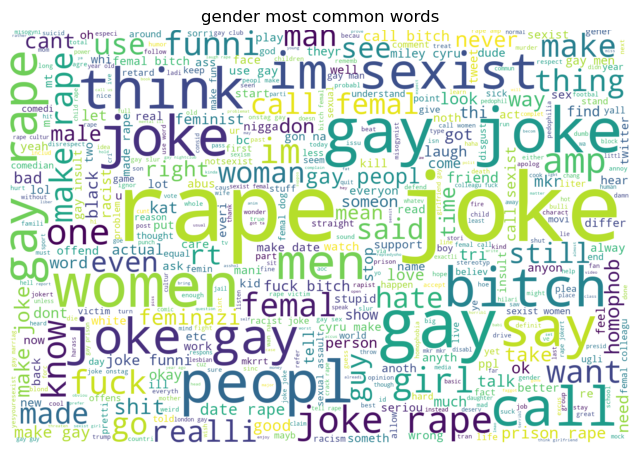

In [30]:
text5 = ''.join(tweet[tweet['cyberbullying_type'] == 'gender'].tweet_text.values)
wc1 = WordCloud(background_color="white", max_words=500, width=1500, height=1000).generate(text5)
plt.figure(figsize=(8,8))
plt.imshow(wc1, interpolation='bilinear')
plt.title('gender most common words')
plt.axis('off')
plt.show()

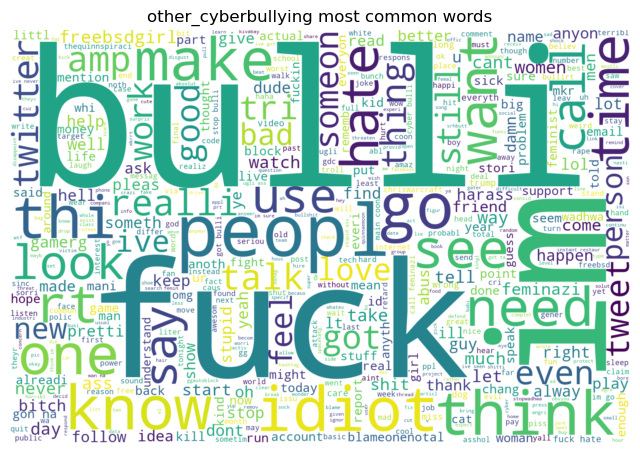

In [31]:
text6 = ''.join(tweet[tweet['cyberbullying_type'] == 'other_cyberbullying'].tweet_text.values)
wc1 = WordCloud(background_color="white", max_words=500, width=1500, height=1000).generate(text6)
plt.figure(figsize=(8,8))
plt.imshow(wc1, interpolation='bilinear')
plt.title('other_cyberbullying most common words')
plt.axis('off')
plt.show()

In [32]:
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word') # n-gram range of 1,1 = unigrams
sparse_matrix = word_vectorizer.fit_transform(tweet[tweet.cyberbullying_type == 'gender'].tweet_text.values)
frequencies = sum(sparse_matrix).toarray()[0]
top_gender_unigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]
top_gender_unigrams

,frequency
joke,5346
rape,4210
gay,4014
call,1404
make,1346
rt,1234
bitch,1160
femal,1110
peopl,996
like,988


In [33]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word') # n-gram range of 2,2 = bigrams
sparse_matrix = word_vectorizer.fit_transform(tweet[tweet.cyberbullying_type == 'gender'].tweet_text.values)
frequencies = sum(sparse_matrix).toarray()[0]
top_gender_bigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]
top_gender_bigrams

,frequency
rape joke,2143
gay joke,754
im sexist,439
joke gay,429
gay rape,427
joke rape,422
make rape,289
call femal,248
gay peopl,228
rape gay,197


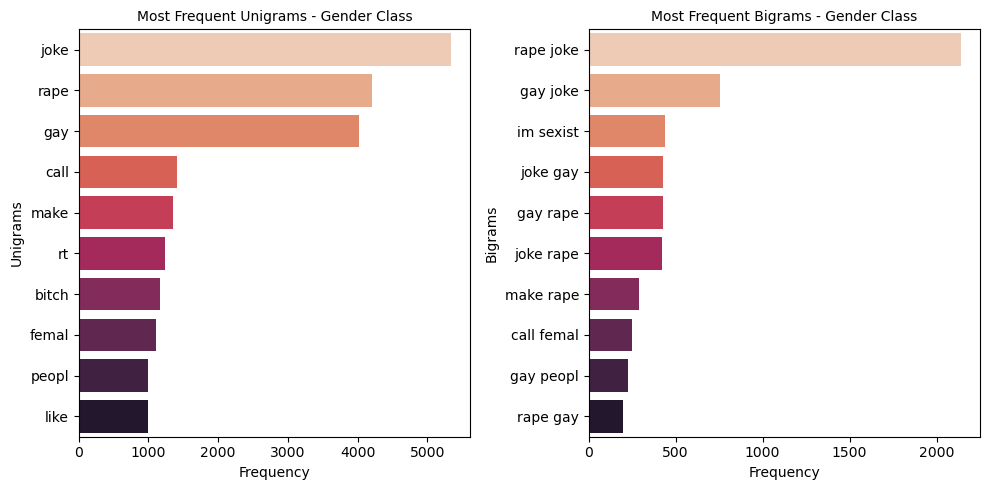

In [34]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sns.barplot(data = top_gender_unigrams, y=top_gender_unigrams.index, x = top_gender_unigrams.frequency, palette = "rocket_r")
plt.title("Most Frequent Unigrams - Gender Class", fontsize = 10)
plt.ylabel('Unigrams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1,2,2)
ax = sns.barplot(data = top_gender_bigrams, y=top_gender_bigrams.index, x = top_gender_bigrams.frequency, palette = "rocket_r")
plt.title("Most Frequent Bigrams - Gender Class", fontsize = 10)
plt.ylabel('Bigrams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

In [35]:
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(tweet[tweet.cyberbullying_type == 'religion'].tweet_text.values)
frequencies = sum(sparse_matrix).toarray()[0]
religion_top_unigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]
religion_top_unigrams

,frequency
muslim,4640
idiot,3083
islam,2462
christian,2151
you,1858
terrorist,1387
right,1303
like,1276
support,1261
terror,1187


In [36]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(tweet[tweet.cyberbullying_type == 'religion'].tweet_text.values)
frequencies = sum(sparse_matrix).toarray()[0]
religion_top_bigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]
religion_top_bigrams

,frequency
islam terror,831
christian woman,817
radic islam,303
you re,208
idiot like,154
you idiot,132
muslim idiot,129
support radic,129
muslim countri,128
radic christian,118


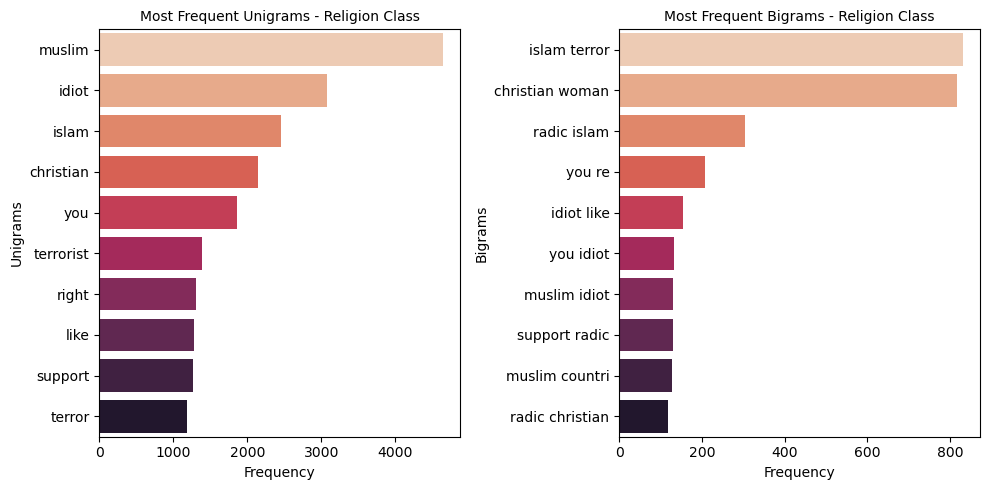

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sns.barplot(data = religion_top_unigrams, y=religion_top_unigrams.index, x = religion_top_unigrams.frequency, palette = "rocket_r")
plt.title("Most Frequent Unigrams - Religion Class", fontsize = 10)
plt.ylabel('Unigrams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1,2,2)
ax = sns.barplot(data = religion_top_bigrams, y=religion_top_bigrams.index, x = religion_top_bigrams.frequency, palette = "rocket_r")
plt.title("Most Frequent Bigrams - Religion Class", fontsize = 10)
plt.ylabel('Bigrams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

In [38]:
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(tweet[tweet.cyberbullying_type == 'age'].tweet_text.values)
frequencies = sum(sparse_matrix).toarray()[0]
age_top_unigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]
age_top_unigrams

,frequency
bulli,9029
school,8546
high,4944
girl,4663
like,2086
it,1117
get,1057
one,1045
peopl,935
got,848


In [39]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(tweet[tweet.cyberbullying_type == 'age'].tweet_text.values)
frequencies = sum(sparse_matrix).toarray()[0]
age_top_bigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]
age_top_bigrams

,frequency
high school,4522
bulli high,1492
school bulli,1411
girl bulli,1399
middl school,577
bulli school,485
girl high,416
got bulli,376
get bulli,337
look like,243


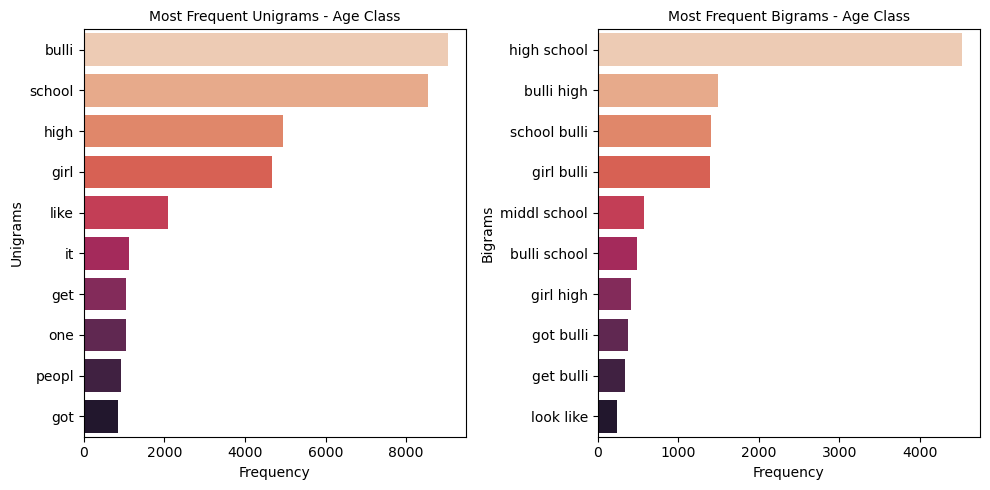

In [40]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sns.barplot(data = age_top_unigrams, y=age_top_unigrams.index, x = age_top_unigrams.frequency, palette = "rocket_r")
plt.title("Most Frequent Unigrams - Age Class", fontsize = 10)
plt.ylabel('Unigrams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)


plt.subplot(1,2,2)
ax = sns.barplot(data = age_top_bigrams, y=age_top_bigrams.index, x = age_top_bigrams.frequency, palette = "rocket_r")
plt.title("Most Frequent Bigrams - Age Class", fontsize = 10)
plt.ylabel('Bigrams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(tweet[tweet.cyberbullying_type == 'ethnicity'].tweet_text.values)
frequencies = sum(sparse_matrix).toarray()[0]
ethnicity_top_unigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]
ethnicity_top_unigrams

,frequency
fuck,6038
nigger,5663
dumb,5155
ass,2283
black,2152
white,1575
you,1417
call,1384
peopl,1189
rt,1155


In [42]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(tweet[tweet.cyberbullying_type == 'ethnicity'].tweet_text.values)
frequencies = sum(sparse_matrix).toarray()[0]
ethnicity_top_bigrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out(), columns=['frequency']).sort_values(by = 'frequency', ascending = False)[:10]
ethnicity_top_bigrams

,frequency
dumb ass,1544
ass nigger,1298
dumb nigger,1183
dumb fuck,1086
fuck obama,990
obama dumb,972
tayyoung fuck,928
fuck dumb,614
rt tayyoung,422
fuck nigger,418


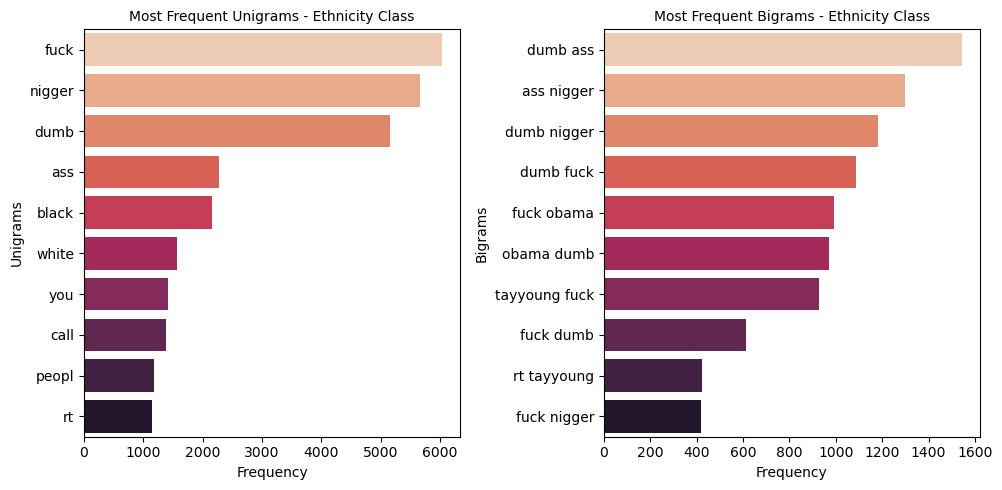

In [43]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
ax = sns.barplot(data = ethnicity_top_unigrams, y=ethnicity_top_unigrams.index, x = ethnicity_top_unigrams.frequency, palette = "rocket_r")
plt.title("Most Frequent Unigrams - Ethnicity Class", fontsize = 10)
plt.ylabel('Unigrams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1,2,2)
ax = sns.barplot(data = ethnicity_top_bigrams, y=ethnicity_top_bigrams.index, x = ethnicity_top_bigrams.frequency, palette = "rocket_r")
plt.title("Most Frequent Bigrams - Ethnicity Class", fontsize = 10)
plt.ylabel('Bigrams', fontsize= 10)
plt.xlabel('Frequency', fontsize= 10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

## TF-IDF (Term Frequency-Inverse Document Frequency)

In [44]:
tfIdfVectorizer = TfidfVectorizer(use_idf = True, sublinear_tf = True)
tfIdf = tfIdfVectorizer.fit_transform(tweet['tweet_text'].tolist())

print(tfIdf)
print(tfIdf.shape)

  (0, 28417)	0.22944224920168435
  (0, 9390)	0.6365579317722767
  (0, 15092)	0.3896510402092516
  (0, 23289)	0.47325087825216533
  (0, 48361)	0.28744354083410656
  (0, 20262)	0.28936505958603165
  (1, 13492)	0.19744167478374477
  (1, 48314)	0.37321657067213265
  (1, 30077)	0.3263671629098098
  (1, 41718)	0.3223867200690178
  (1, 42014)	0.3595139973111559
  (1, 44400)	0.1846512521130566
  (1, 20091)	0.3360892934299945
  (1, 43418)	0.3595139973111559
  (1, 47847)	0.13978792643819984
  (1, 3028)	0.37321657067213265
  (1, 47817)	0.16969687993527896
  (1, 28417)	0.13452294777938217
  (2, 9758)	0.4112508390969922
  (2, 46594)	0.4459716313656257
  (2, 36138)	0.3071366124880639
  (2, 31966)	0.2640858311295716
  (2, 47933)	0.3227895431184037
  (2, 8156)	0.3566593647495913
  (2, 48745)	0.4863217400187787
  :	:
  (46014, 16835)	0.21455115769546973
  (46014, 43857)	0.17094625595997115
  (46015, 43706)	0.5454189336892558
  (46015, 30423)	0.27467314684981836
  (46015, 45971)	0.390146699774303
  (460

In [45]:
scores = zip(tfIdfVectorizer.get_feature_names_out(), np.asarray(tfIdf.sum(axis=0)).ravel())
scores_df = pd.DataFrame(scores, columns=['word', 'score'])
top_words = scores_df.sort_values(by='score', ascending=False).head(25)
output = top_words.apply(lambda row: f"{row['word']:50} Scores: {row['score']}", axis=1)
print("\n".join(output))

bulli                                              Scores: 1246.6410484733344
school                                             Scores: 1090.0624046605665
fuck                                               Scores: 1076.1686316852513
nigger                                             Scores: 862.5209383619728
dumb                                               Scores: 837.4033319219595
like                                               Scores: 752.7461054388319
high                                               Scores: 749.4452910327078
girl                                               Scores: 749.0077985943145
joke                                               Scores: 704.8730641353353
you                                                Scores: 636.4998393779898
rt                                                 Scores: 623.083013155096
rape                                               Scores: 615.1316344123596
gay                                                Scores: 609.40404805726

In [46]:
label_encoder = preprocessing.LabelEncoder()
tweet['cyberbullying_type']= label_encoder.fit_transform(tweet['cyberbullying_type'])
tweet['cyberbullying_type'].unique()

array([3, 2, 5, 4, 0, 1])

In [47]:
X = tfIdf
y = np.array(tweet['cyberbullying_type'])

#splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36813, 49847)
(36813,)
(9204, 49847)
(9204,)


## Naive Bayes Classifier

In [48]:
mnb_cl=MultinomialNB()
mnb_cl

MultinomialNB()

In [49]:
mnb_cl.fit(X_train, y_train)
mnb_pred = mnb_cl.predict(X_test)
mnb_pred

array([5, 2, 0, ..., 2, 1, 1])

In [51]:
nb_accuracy = accuracy_score(y_test, mnb_pred)
print("Accuracy: ", nb_accuracy)

Accuracy:  0.7438070404172099


In [69]:
print('Classification Report for Random Forest:\n', classification_report(y_test,mnb_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.65      0.99      0.79      1590
           1       0.83      0.93      0.87      1600
           2       0.82      0.85      0.84      1605
           3       0.68      0.40      0.50      1588
           4       0.64      0.19      0.29      1231
           5       0.76      0.98      0.86      1590

    accuracy                           0.74      9204
   macro avg       0.73      0.72      0.69      9204
weighted avg       0.73      0.74      0.71      9204



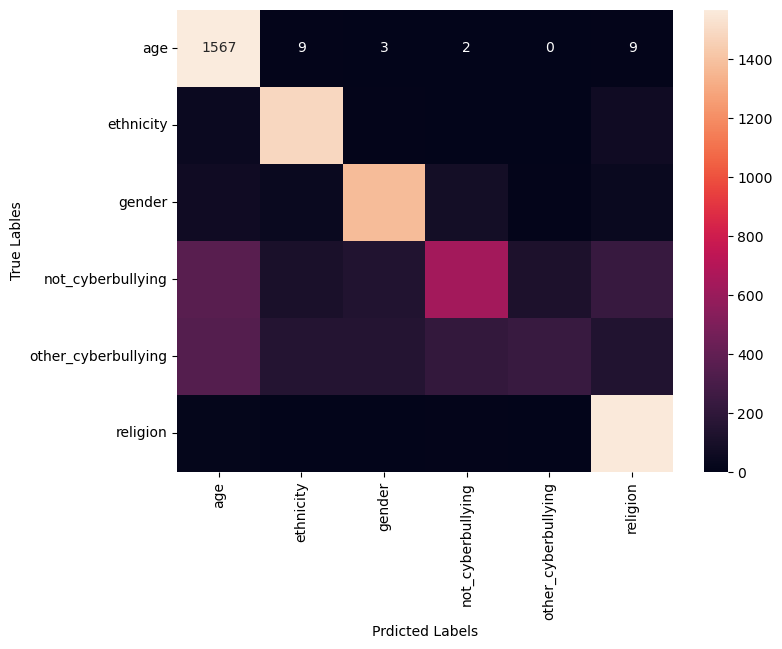

In [52]:
plt.figure(figsize=(8,6))
cm_labels = np.unique(label_encoder.inverse_transform(y_test))
cm = confusion_matrix(y_test, mnb_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show()

## AdaBoostClassifier

In [134]:
adaboost_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_clf

AdaBoostClassifier(random_state=42)

In [135]:
adaboost_clf.fit(X_train, y_train)
ada_pred = adaboost_clf.predict(X_test)
ada_pred

array([5, 2, 0, ..., 2, 0, 1])

In [136]:
ada_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", ada_accuracy)

Accuracy: 0.7892220773576706


In [67]:
print('Classification Report for Random Forest:\n', classification_report(y_test,ada_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1590
           1       0.98      0.97      0.97      1600
           2       0.92      0.77      0.84      1605
           3       0.49      0.71      0.58      1588
           4       0.42      0.26      0.32      1231
           5       0.95      0.94      0.94      1590

    accuracy                           0.79      9204
   macro avg       0.78      0.77      0.77      9204
weighted avg       0.80      0.79      0.79      9204



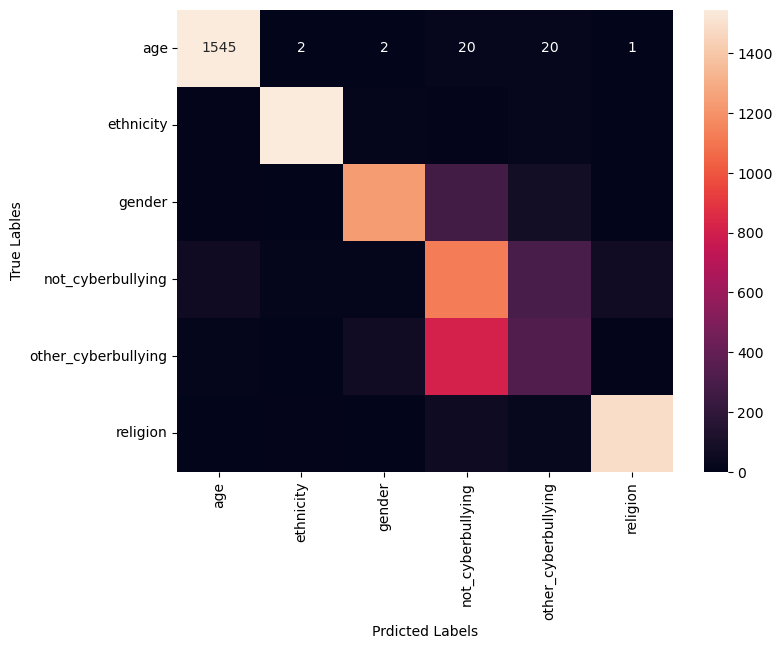

In [68]:
plt.figure(figsize=(8,6))
cm_labels = np.unique(label_encoder.inverse_transform(y_test))
cm = confusion_matrix(y_test, ada_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show()

## Random Forest Classifier

In [53]:
rf_cl = RandomForestClassifier(random_state=50)
rf_cl

RandomForestClassifier(random_state=50)

In [54]:
rf_cl.fit(X_train, y_train)
rf_pred = rf_cl.predict(X_test)
rf_pred

array([5, 2, 0, ..., 2, 4, 1])

In [55]:
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy: ", rf_accuracy)

Accuracy:  0.8521295089091699


In [57]:
print('Classification Report for Random Forest:\n', classification_report(y_test,rf_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1590
           1       0.98      0.99      0.98      1600
           2       0.92      0.84      0.88      1605
           3       0.65      0.64      0.65      1588
           4       0.59      0.65      0.62      1231
           5       0.95      0.97      0.96      1590

    accuracy                           0.85      9204
   macro avg       0.85      0.84      0.84      9204
weighted avg       0.86      0.85      0.85      9204



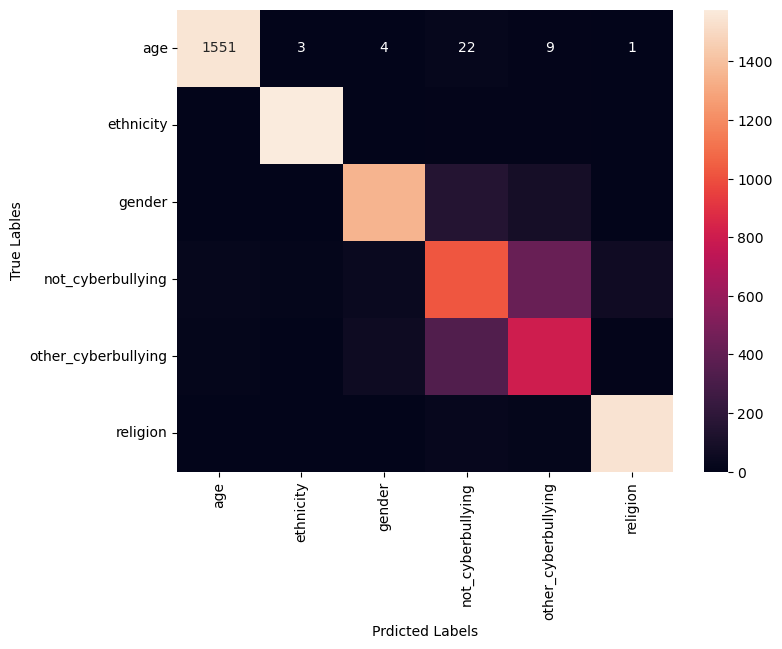

In [58]:
plt.figure(figsize=(8,6))
cm_labels = np.unique(label_encoder.inverse_transform(y_test))
cm = confusion_matrix(y_test, rf_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show()

## Logistic Regression

In [137]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg

LogisticRegression(max_iter=1000, random_state=42)

In [138]:
log_reg.fit(X_train, y_train)
logi_pred = log_reg.predict(X_test)
logi_pred

array([5, 2, 3, ..., 2, 4, 1])

In [139]:
lr_accuracy = accuracy_score(y_test, logi_pred)
print("Accuracy:", lr_accuracy)

Accuracy: 0.8540851803563668


In [74]:
print('Classification Report for Random Forest:\n', classification_report(y_test,logi_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1590
           1       0.98      0.98      0.98      1600
           2       0.93      0.84      0.88      1605
           3       0.64      0.69      0.66      1588
           4       0.63      0.65      0.64      1231
           5       0.96      0.95      0.95      1590

    accuracy                           0.85      9204
   macro avg       0.85      0.85      0.85      9204
weighted avg       0.86      0.85      0.86      9204



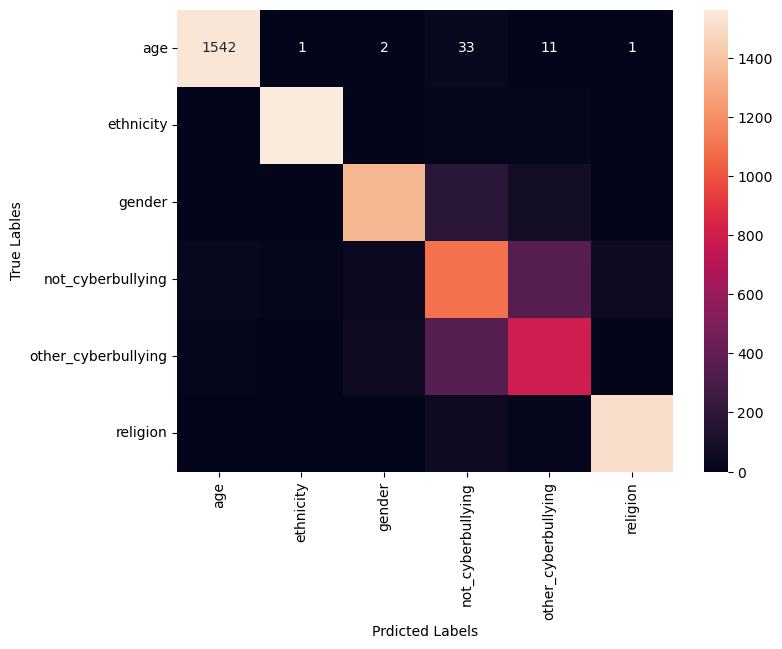

In [75]:
plt.figure(figsize=(8,6))
cm_labels = np.unique(label_encoder.inverse_transform(y_test))
cm = confusion_matrix(y_test, logi_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show()

## Decision Tree Classifier

In [140]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf

DecisionTreeClassifier(random_state=42)

In [141]:
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
dt_pred

array([5, 2, 0, ..., 2, 4, 1])

In [142]:
dt_accuracy = accuracy_score(y_test, dt_pred)
print("Accuracy:", dt_accuracy)

Accuracy: 0.8245328118209474


In [79]:
print('Classification Report for Random Forest:\n', classification_report(y_test,dt_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1590
           1       0.98      0.97      0.98      1600
           2       0.87      0.84      0.86      1605
           3       0.59      0.59      0.59      1588
           4       0.54      0.59      0.56      1231
           5       0.95      0.94      0.94      1590

    accuracy                           0.82      9204
   macro avg       0.82      0.82      0.82      9204
weighted avg       0.83      0.82      0.83      9204



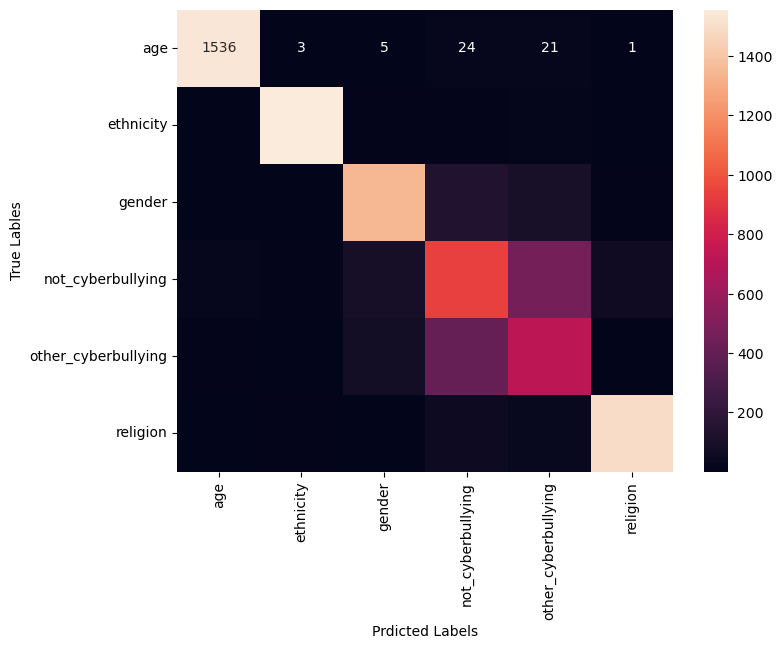

In [80]:
plt.figure(figsize=(8,6))
cm_labels = np.unique(label_encoder.inverse_transform(y_test))
cm = confusion_matrix(y_test, dt_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show()

## Support Vector Classifier

In [143]:
svc = SVC(kernel='linear', random_state=42)
svc

SVC(kernel='linear', random_state=42)

In [144]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_pred

array([5, 2, 3, ..., 2, 1, 1])

In [145]:
svc_accuracy = accuracy_score(y_test, svc_pred)
print("Accuracy:", svc_accuracy)

Accuracy: 0.8532159930465015


In [86]:
print('Classification Report for Random Forest:\n', classification_report(y_test,svc_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1590
           1       0.98      0.98      0.98      1600
           2       0.93      0.86      0.89      1605
           3       0.64      0.66      0.65      1588
           4       0.62      0.65      0.63      1231
           5       0.96      0.95      0.95      1590

    accuracy                           0.85      9204
   macro avg       0.85      0.85      0.85      9204
weighted avg       0.86      0.85      0.85      9204



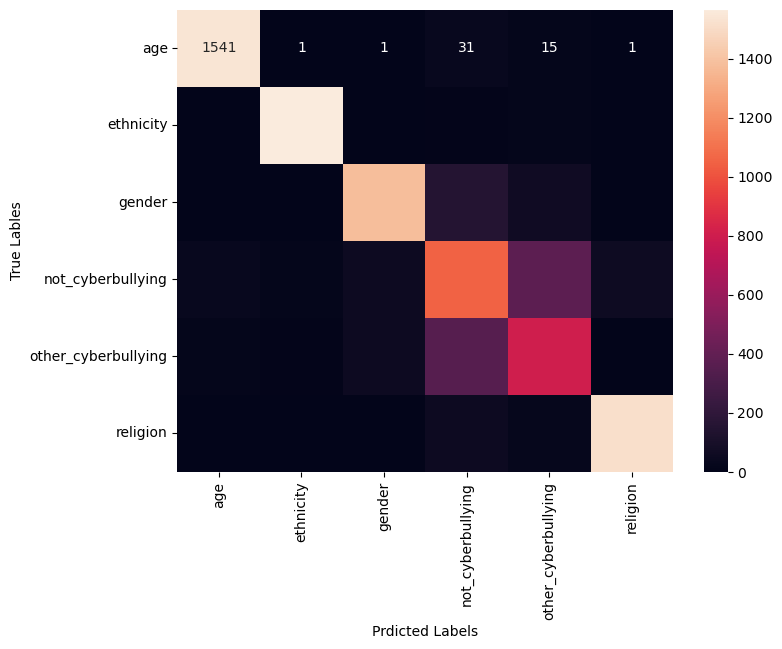

In [87]:
plt.figure(figsize=(8,6))
cm_labels = np.unique(label_encoder.inverse_transform(y_test))
cm = confusion_matrix(y_test, svc_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show()

## K-Nearest Neighbors

In [146]:
knn = KNeighborsClassifier(n_neighbors=700)
knn

KNeighborsClassifier(n_neighbors=700)

In [147]:
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_pred

array([5, 2, 0, ..., 2, 0, 1])

In [148]:
knn_accuracy = accuracy_score(y_test, knn_pred)
print("Accuracy:", knn_accuracy)

Accuracy: 0.7531508039982616


In [132]:
print('Classification Report for Random Forest:\n', classification_report(y_test,knn_pred))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79      1590
           1       0.83      0.99      0.90      1600
           2       0.88      0.79      0.83      1605
           3       0.72      0.26      0.38      1588
           4       0.52      0.45      0.49      1231
           5       0.83      0.96      0.89      1590

    accuracy                           0.75      9204
   macro avg       0.74      0.74      0.72      9204
weighted avg       0.75      0.75      0.72      9204



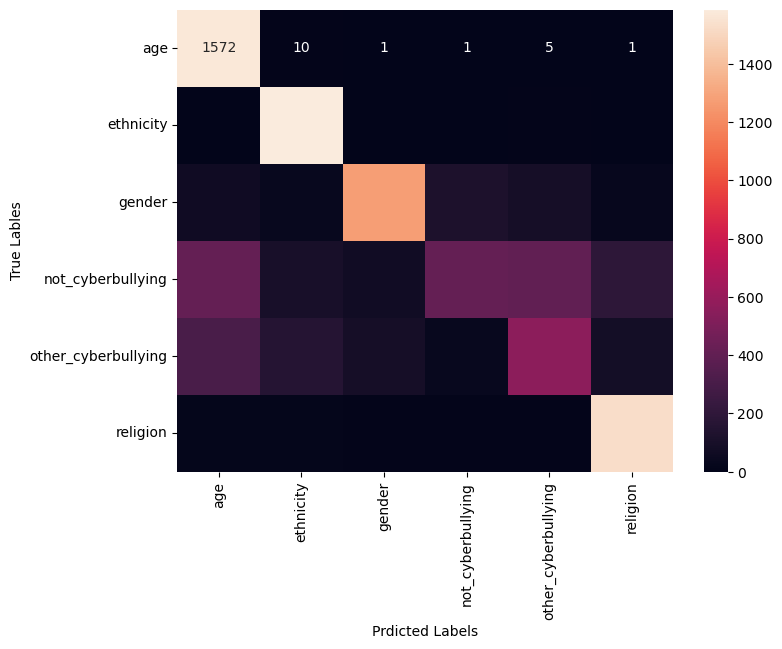

In [133]:
plt.figure(figsize=(8,6))
cm_labels = np.unique(label_encoder.inverse_transform(y_test))
cm = confusion_matrix(y_test, knn_pred)
cm_df = pd.DataFrame(cm, index = cm_labels, columns = cm_labels)

ax = sns.heatmap(cm_df, annot=True, fmt='d')
ax.set_xlabel('Prdicted Labels')
ax.set_ylabel('True Lables')

plt.show()

In [151]:
# Results for each model
results = {
    'Model': ['Navie Bayes Classifier', 'AdaBoost Classifer', 'Random Forest Classifier', 'Logistic Regression',
              'Decision Tree Classifier', 'Support Vector Machine', 'K-Nearest Neigbors'],
    'Accuracy': [nb_accuracy, ada_accuracy, rf_accuracy, lr_accuracy, dt_accuracy, svc_accuracy, knn_accuracy],
}

# Create DataFrame
results_df = pd.DataFrame(results)

# Display DataFrame
results_df

,Model,Accuracy
0,Navie Bayes Classifier,0.743807
1,AdaBoost Classifer,0.789222
2,Random Forest Classifier,0.852130
3,Logistic Regression,0.854085
4,Decision Tree Classifier,0.824533
5,Support Vector Machine,0.853216
6,K-Nearest Neigbors,0.753151


### From the above classified result, `Logistic Regression`,`Random Forest Classifier`,`Support Vector Machine` performed very well with accuracy of 85%.